## Preprocessing Qubicc

Converting the data into npy makes it possible for us to work with it efficiently; originally we require 500GB of RAM which is always difficult to guarantee. We preprocess QUBICC in another ipynb notebook precisely because of this issue.

1) We read the data
2) Reshape variables so that they have equal dimensionality
3) Reshape into data samples fit for the NN and convert into a DataFrame
4) Downsample the data: Remove data above 21kms, remove condensate-free clouds, combat class-imbalance
5) Split into input and output
6) Save as npy

Note: We neither scale nor split the data into training/validation/test sets. <br>
The reason is that i) in order to scale we need the entire dataset but this can only be done in conjunction with the Qubicc dataset. Also for cross-validation different scalings will be necessary based on different subsets of the data, ii) The split into subsets will be done by the cross-validation procedure or not at all when training the final model.

In [1]:
# Ran with 900GB

import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
# import importlib
# importlib.reload(my_classes)

base_path = '/pf/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/based_on_var_interpolated_data'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

# Which days to load
days_qubicc = 'all_hcs'

from my_classes import load_data

VERT_LAYERS = 31

## Parameters for the notebook

#Set a numpy seed for the permutation later on!
np.random.seed(10)

# Set output_var to one of {'cl', 'cl_area'}
output_var = 'cl_area'

## Reading the data
### Input:
- fr_land: Fraction of land
- coriolis: Coriolis parameter
- zg: Geometric height at full levels (3D)
- qv: Specific water vapor content (3D)
- qc: Specific cloud water content (3D)
- qi: Specific cloud ice content (3D)
- temp: Temperature (3D)
- pres: Pressure (3D)
- u: Zonal wind (3D)
- v: Meridional wind (3D)

$10$ input nodes

### Output:
- clc: Cloud Cover

$1$ output nodes

The data above 21km is capped.

In [2]:
# For cl_area I only need the output as I already have the input
# I still need 'clw', 'cli', 'cl' for condensate-free clouds
# If I were to use 'cl_area' for condensate-free clouds I would get an estimate 
# which is slightly different due to coarse-graining

order_of_vars_qubicc = ['hus', 'clw', 'cli', 'ta', 'pfull', 'ua', 'va', 'zg', 'coriolis', 'fr_land', output_var]

In [ ]:
# Load QUBICC data
data_dict = load_data(source='qubicc', days=days_qubicc, resolution='R02B05', 
                             order_of_vars=order_of_vars_qubicc)

In [ ]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

In [5]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict[output_var].shape

In [6]:
try:
    #Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 0), TIME_STEPS, axis=0)
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 1), VERT_LAYERS, axis=1)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), TIME_STEPS, axis=0)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 1), VERT_LAYERS, axis=1)
except:
    pass

In [7]:
# Remove the first timesteps of the QUBICC simulations since the clc values are 0 across the entire earth there 
# Convert the data to float32!
remove_steps = []
for i in range(data_dict[output_var].shape[0]):
    if np.all(data_dict[output_var][i,4:,:] == 0):
        remove_steps.append(i)
        TIME_STEPS = TIME_STEPS - 1

for key in data_dict.keys():
    data_dict[key] = np.float32(np.delete(data_dict[key], remove_steps, axis=0))

In [8]:
# Our Neural Network has trained with clc in [0, 100]!
data_dict[output_var] = 100*data_dict[output_var]
np.max(data_dict[output_var][:, 4:, :])

100.0

In [9]:
# Carry along information about the vertical layer of a grid cell. int16 is sufficient for < 1000.
vert_layers = np.int16(np.repeat(np.expand_dims(np.arange(1, VERT_LAYERS+1), 0), TIME_STEPS, axis=0))
vert_layers = np.repeat(np.expand_dims(vert_layers, 2), HORIZ_FIELDS, axis=2)
vert_layers.shape

(2159, 31, 78069)

In [10]:
### Subsample QUBICC data further

# We reduce the data size to using only every three hours from the QUBICC data.
# The reason is that training is almost impossible with a total data size of 3.6 Billion samples (from NARVAL we have 126 Mio samples). 
# To make it feasible we would need a training batch size of ~5000.
# Therefore we need to decrease the amount of samples further. 
# We decrease the amount of QUBICC samples as they are less reliable than the NARVAL samples. 
# We split the dataset in half by only taking into account every three hours (we assume 
# a relatively high temporal correlation).

for key in order_of_vars_qubicc:
    data_dict[key] = data_dict[key][0::3]
vert_layers = vert_layers[0::3]

In [11]:
# Reshaping into 1D-arrays and converting dict into a DataFrame-object (the following is based on Aurelien Geron)
# Remove data above 21kms
for key in order_of_vars_qubicc:
    data_dict[key] = np.reshape(data_dict[key][:, 4:, :], -1)

vert_layers = np.reshape(vert_layers[:, 4:, :], -1)

In [12]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

clw (1517661360,)
cli (1517661360,)
cl (1517661360,)
cl_area (1517661360,)


In [13]:
df = pd.DataFrame.from_dict(data_dict)

# Number of samples/rows
len(df)

1517661360

In [14]:
import gc
del data_dict
gc.collect()

11834

**Downsampling the data (minority class: clc = 0)**

In [15]:
# There are no nans left
assert np.all(np.isnan(df) == False) == True

In [16]:
# Remove condensate-free clouds (7.3% of clouds)
df = df.loc[~((df['cl'] > 0) & (df['clw'] == 0) & (df['cli'] == 0))]

In [17]:
# We ensure that clc != 0 is twice as large as clc = 0 (which then has 294 Mio samples) and keep the original order intact
df_noclc = df.loc[df['cl']==0]
print(len(df_noclc))

# len(downsample_indices) will be the number of noclc samples that remain
downsample_ratio = (len(df) - len(df_noclc))/len(df_noclc)
shuffled_indices = np.random.permutation(df.loc[df['cl']==0].index)
size_noclc = int(len(df_noclc)*downsample_ratio)//2 #Different from other notebooks. Division by 2 here.
downsample_indices = shuffled_indices[:size_noclc] 

# Concatenate df.loc[df[output_var]!=0].index and downsample_indices
final_indices = np.concatenate((downsample_indices, df.loc[df['cl']!=0].index))

# Sort final_indices so that we can more or less recover the timesteps
final_indices = np.sort(final_indices)

# Label-based (loc) not positional-based
df = df.loc[final_indices]

920713771


In [18]:
# Number of samples after downsampling
len(df)

882478606

In [19]:
#Modifies df as well
def split_input_output(dataset):
    output_df = dataset[output_var]
    del dataset[output_var]
    return output_df

In [20]:
output_df = split_input_output(df)

In [21]:
# Save the data
if output_var == 'cl':
    np.save(output_path + '/cloud_cover_input_qubicc.npy', df)
    np.save(output_path + '/cloud_cover_output_qubicc.npy', output_df)
elif output_var == 'cl_area':
    np.save(output_path + '/cloud_area_output_qubicc.npy', output_df)

# Save the corresponding vertical layers
if output_var == 'cl':
    np.save(output_path + '/samples_vertical_layers_qubicc.npy', vert_layers[df.index])

#### Some tests of the cloud area output

Test whether qi from the saved data coincides with the qi here

In [22]:
if output_var == 'cl_area':
    old_input = np.load(output_path + '/cloud_cover_input_qubicc.npy')
    # If this yields True then we're done
    print(np.all(old_input[:,2] == df['cli']))

True


In [2]:
clc = np.load(output_path + '/cloud_cover_output_qubicc.npy')
cl_area = np.load(output_path + '/cloud_area_output_qubicc.npy')

diff = cl_area - clc

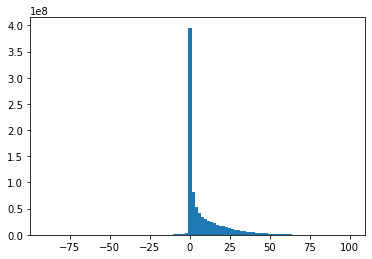

In [3]:
plt.hist(diff, bins = 100)
plt.show()

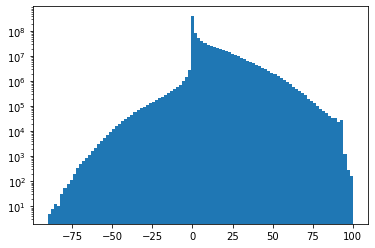

In [4]:
plt.hist(diff, bins = 100, log=True)
plt.show()

In [5]:
# These are anomalies existing due to differences in coarse-graining
len(np.where(diff < 0)[0])

13731860

In [6]:
len(np.where(diff > 0)[0])

567517791

In [7]:
len(np.where(diff >= 0)[0])

868746746

In [8]:
len(np.where(diff < 0)[0])/len(diff) # 1.56% of the data

0.015560558529846105

In [9]:
len(np.where(diff < 0)[0])/len(np.where(diff != 0)[0]) # 2.36% of cloudy data

0.023624719561336993